# Sklearn
Logistic Regression Classifier for Text

In [3]:
import os
import sys
import tarfile
import time
import urllib.request

source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

if os.path.exists(target):
    os.remove(target)

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    #duration = time.time() - start_time
    duration = 1
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size

    sys.stdout.write(f'\r{int(percent)}% | {progress_size / (1024.**2):.2f} MB '
                     f'| {speed:.2f} MB/s | {duration:.2f} sec elapsed')
    sys.stdout.flush()


if not os.path.isdir('aclImdb') and not os.path.isfile('aclImdb_v1.tar.gz'):
    urllib.request.urlretrieve(source, target, reporthook)

100% | 80.23 MB | 80.23 MB/s | 1.00 sec elapsed

In [4]:
if not os.path.isdir('aclImdb'):

    with tarfile.open(target, 'r:gz') as tar:
        tar.extractall()

Preprocessing the movie dataset into more convenient format

In [5]:
import pandas as pd
import os
import sys
from packaging import version


# change the `basepath` to the directory of the
# unzipped movie dataset

basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}

df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
                
            if version.parse(pd.__version__) >= version.parse("1.3.2"):
                x = pd.DataFrame([[txt, labels[l]]], columns=['review', 'sentiment'])
                df = pd.concat([df, x], ignore_index=False)

            else:
                df = df.append([[txt, labels[l]]], 
                               ignore_index=True)
df.columns = ['review', 'sentiment']

Shuffling the DataFrame:

In [6]:
import numpy as np


if version.parse(pd.__version__) >= version.parse("1.3.2"):
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    
else:
    np.random.seed(0)
    df = df.reindex(np.random.permutation(df.index))



'''
df = pd.read_csv('movie_data.csv', encoding='utf-8')
# the following is necessary on some computers:
df = df.rename(columns={"0": "review", "1": "sentiment"})
'''
df.head(3)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


Training a logistic regression model for document classification

In [7]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [8]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [9]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [10]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')
 if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__norm':[None],
                     'clf__penalty': ['l2'],
                  'clf__C': [1.0, 10.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=8)

In [12]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Program Files\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=8,
             param_grid=[{'clf__C': [1.0, 10.0], 'clf__penalty': ['l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [None],
                          'vect__tokenizer': [<function tokenizer at 0x00000172F5169A80>,
                                              <function tokenizer_porter at 0x000001728...
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x00000172F5169A80>],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=1)

In [13]:
print(f'Best parameter set: {gs_lr_tfidf.best_params_}')
print(f'CV Accuracy: {gs_lr_tfidf.best_score_:.3f}')

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x00000172F5169A80>}
CV Accuracy: 0.887


In [14]:
clf = gs_lr_tfidf.best_estimator_
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')

Test Accuracy: 0.893


# Tensorflow

In [15]:
from tensorflow.keras.datasets import imdb

(data_train, label_train), (data_test, label_test) = imdb.load_data(num_words=1000)
data_train.shape, data_train[0]


17464789/17464789 [==============================] - 3s 0us/step


((25000,),
 [1,
  14,
  22,
  16,
  43,
  530,
  973,
  2,
  2,
  65,
  458,
  2,
  66,
  2,
  4,
  173,
  36,
  256,
  5,
  25,
  100,
  43,
  838,
  112,
  50,
  670,
  2,
  9,
  35,
  480,
  284,
  5,
  150,
  4,
  172,
  112,
  167,
  2,
  336,
  385,
  39,
  4,
  172,
  2,
  2,
  17,
  546,
  38,
  13,
  447,
  4,
  192,
  50,
  16,
  6,
  147,
  2,
  19,
  14,
  22,
  4,
  2,
  2,
  469,
  4,
  22,
  71,
  87,
  12,
  16,
  43,
  530,
  38,
  76,
  15,
  13,
  2,
  4,
  22,
  17,
  515,
  17,
  12,
  16,
  626,
  18,
  2,
  5,
  62,
  386,
  12,
  8,
  316,
  8,
  106,
  5,
  4,
  2,
  2,
  16,
  480,
  66,
  2,
  33,
  4,
  130,
  12,
  16,
  38,
  619,
  5,
  25,
  124,
  51,
  36,
  135,
  48,
  25,
  2,
  33,
  6,
  22,
  12,
  215,
  28,
  77,
  52,
  5,
  14,
  407,
  16,
  82,
  2,
  8,
  4,
  107,
  117,
  2,
  15,
  256,
  4,
  2,
  7,
  2,
  5,
  723,
  36,
  71,
  43,
  530,
  476,
  26,
  400,
  317,
  46,
  7,
  4,
  2,
  2,
  13,
  104,
  88,
  4,
  381,
  15,
  297

In [22]:
label_train[0]

1

decoding

In [23]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in data_train[0]])
decoded_review

"? this film was just brilliant casting ? ? story direction ? really ? the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same ? ? as myself so i loved the fact there was a real ? with this film the ? ? throughout the film were great it was just brilliant so much that i ? the film as soon as it was released for ? and would recommend it to everyone to watch and the ? ? was amazing really ? at the end it was so sad and you know what they say if you ? at a film it must have been good and this definitely was also ? to the two little ? that played the ? of ? and paul they were just brilliant children are often left out of the ? ? i think because the stars that play them all ? up are such a big ? for the whole film but these children are amazing and should be ? for what they have done don't you think the whole story was so ? because it was true and was ? life after all that was ? with us all"

Data prerprocessing

In [24]:
import numpy as np

def vectorize_sequences(sequences, dimension=1000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1
    return results

x_train = vectorize_sequences(data_train)
x_test = vectorize_sequences(data_test)
x_train.shape, x_train[0]

((25000, 1000),
 array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

In [25]:
y_train = np.asarray(label_train).astype('float32')
y_test = np.asarray(label_test).astype('float32')
y_train.shape, y_test.shape

((25000,), (25000,))

Model building

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [34]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [28]:
x_val = x_train[:10000]
x_train = x_train[10000:]
y_val = y_train[:10000]
y_train = y_train[10000:]

x_val.shape, y_val.shape, x_train.shape, y_train.shape

((10000, 1000), (10000,), (15000, 1000), (15000,))

In [35]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 9ms/step - loss: 0.2442 - accuracy: 0.9001 - val_loss: 0.3598 - val_accuracy: 0.8516
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2344 - accuracy: 0.9043 - val_loss: 0.3676 - val_accuracy: 0.8499
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2293 - accuracy: 0.9079 - val_loss: 0.3579 - val_accuracy: 0.8535
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2224 - accuracy: 0.9108 - val_loss: 0.3604 - val_accuracy: 0.8541
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2158 - accuracy: 0.9136 - val_loss: 0.3638 - val_accuracy: 0.8520
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2104 - accuracy: 0.9169 - val_loss: 0.3665 - val_accuracy: 0.8525
Epoch 7/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2051 - accuracy: 0.9181 - val_loss: 0.3796 - val_accuracy: 0.8511
Epoch 8/20
30/30 [==

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

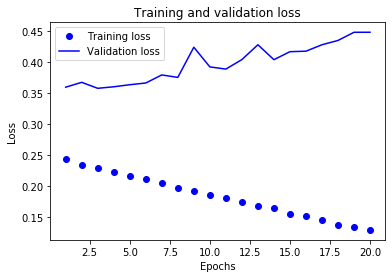

In [36]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

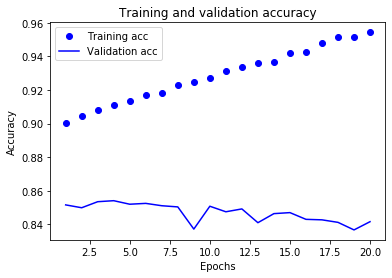

In [37]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Overfitting

In [39]:
model = Sequential([
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(x_train, y_train, epochs=4, batch_size=512)
model.evaluate(x_val, y_val)

Epoch 1/4
30/30 [==============================] - 0s 3ms/step - loss: 0.5951 - accuracy: 0.7069
Epoch 2/4
30/30 [==============================] - 0s 3ms/step - loss: 0.4324 - accuracy: 0.8261
Epoch 3/4
30/30 [==============================] - 0s 3ms/step - loss: 0.3625 - accuracy: 0.8539
Epoch 4/4
313/313 [==============================] - 0s 693us/step - loss: 0.3544 - accuracy: 0.8523


[0.3543745279312134, 0.8522999882698059]

In [40]:
model.predict(x_test)

array([[0.4359344 ],
       [0.99171543],
       [0.7744141 ],
       ...,
       [0.19002044],
       [0.24499428],
       [0.5078208 ]], dtype=float32)